In [1]:
import os
from scipy.io import loadmat
import pandas as pd
import kagglehub
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

## General rules
1. update group when working and what sections
2. Try to be comprehensive as you write! Leave short markdown descriptions for the average reader to understand what you're doing

## Overview
### [FILL IN WITH PROJECT DESCRIPTION]

## Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/blackbirdsix/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1


In [3]:
# Explore directories/files
print("Path:", path)
print("Folders/files inside the dataset:")
dir = os.listdir(path)
print(dir)
devpath = path + '/car_devkit/devkit'
print('Files inside devkit')
print(os.listdir(devpath))
metapath = devpath + "/cars_meta.mat"

Path: /Users/blackbirdsix/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1
Folders/files inside the dataset:
['cars_train', '.DS_Store', 'cars_test', 'car_devkit']
Files inside devkit
['cars_test_annos.mat', 'eval_train.m', 'cars_meta.mat', 'README.txt', 'cars_train_annos.mat', 'train_perfect_preds.txt']


In [4]:
meta = loadmat(metapath)

train_dir = os.path.join(path, 'cars_train' )
test_dir = os.path.join(path, 'cars_test')
class_names = [c[0] for c in meta["class_names"][0]]
class_index = range(1, len(class_names) + 1) # classes are labeled w/ 1 based labeling

classes = pd.DataFrame( {
    "label": class_index,
    "class_names" : class_names
})
classes

,label,class_names
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012
...,...,...
191,192,Volkswagen Beetle Hatchback 2012
192,193,Volvo C30 Hatchback 2012
193,194,Volvo 240 Sedan 1993
194,195,Volvo XC90 SUV 2007


In [5]:
train_ann = loadmat(os.path.join(devpath, 'cars_train_annos.mat'))
train_ann = train_ann["annotations"][0] # index 4 is label for each train image
test_ann = loadmat(os.path.join(devpath, 'cars_test_annos.mat'))
test_ann = test_ann["annotations"][0] # no test labels, will split up train_ann to train/test
train_labels = [i[4][0][0] for i in train_ann]
file_names = [i[5][0] for i in train_ann]


data_dict = {
    "filen" : file_names,
    "train_labels" : train_labels
}

data = pd.DataFrame(data_dict)

data["class_name"] = data["train_labels"].map(
    dict(zip(classes["label"], classes["class_names"]))
)
data

,filen,train_labels,class_name
0,00001.jpg,14,Audi TTS Coupe 2012
1,00002.jpg,3,Acura TL Sedan 2012
2,00003.jpg,91,Dodge Dakota Club Cab 2007
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012
...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012
8140,08141.jpg,196,smart fortwo Convertible 2012
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009
8142,08143.jpg,112,Ford GT Coupe 2006


## Body types work:

In [6]:
body_types = [
    "Coupe", "Sedan", "SUV", "Hatchback",
    "Convertible", "Minivan", "Wagon", "Crossover", "Van", "Cab"
]

def find_body_type(name):
    name_lower = name.lower()
    
    for body in body_types:
        if body.lower() in name_lower:
            return body
    #coupes
    if any(x in name_lower for x in ["corvette", "camaro", "mustang", "challenger", "370z", "350z", "supra", "xk", "xkr", "integra", "gallardo"]):
        return "Coupe"

    # Sedans
    if any(x in name_lower for x in ["charger", "chrysler 300", "cobalt", "impala", "malibu", "accord", "civic", "corolla", 
                                     "jetta", "regal", "tl type-s"]):
        return "Sedan"

    # SUVs 
    if any(x in name_lower for x in ["grand cherokee", "cherokee", "durango", "rav4", "cr-v", "crv", "rogue", "highlander", "pilot", "tahoe", 
                                     "explorer", "escape", "equinox","trailblazer"]):
        return "SUV"

    #hatchbacks
    if any(x in name_lower for x in ["golf", "fit", "hhr", "impreza hatch", "mazda3 hatch", "sportwagen","fiat 500"]):
        return "Hatchback"

    # Trucks
    if any(x in name_lower for x in ["f-150", "f150", "f-250", "ram", "silverado", "sierra", "tacoma", "tundra", "ranger", "colorado"]):
        return "Truck"

    # Vans / Minivans
    if any(x in name_lower for x in ["caravan", "odyssey", "sienna", "transit", "express van", "sprinter"]):
        return "Van"

    # other
    if "srt" in name_lower or "ss" in name_lower or "hellcat" in name_lower or "z06" in name_lower or "zl1" in name_lower:
        if any(x in name_lower for x in ["charger", "chrysler 300", "cts"]):
            return "Sedan"
        if any(x in name_lower for x in ["corvette", "camaro", "challenger", "mustang"]):
            return "Coupe"

    if "cab" in name_lower:
        return "Cab"
    return "Unknown"

data["body type"] = data["class_name"].apply(find_body_type)
data.loc[data["body type"] == "Cab", "body type"] = "Truck"
data.loc[data["body type"] == "Minivan", "body type"] = "Van"

In [7]:
data

,filen,train_labels,class_name,body type
0,00001.jpg,14,Audi TTS Coupe 2012,Coupe
1,00002.jpg,3,Acura TL Sedan 2012,Sedan
2,00003.jpg,91,Dodge Dakota Club Cab 2007,Truck
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012,Sedan
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012,Truck
...,...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012,Van
8140,08141.jpg,196,smart fortwo Convertible 2012,Convertible
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009,Coupe
8142,08143.jpg,112,Ford GT Coupe 2006,Coupe


In [8]:
# Show that all data is labeled
unknowns = data[data["body type"] == "Unknown"]
print(unknowns)


Empty DataFrame
Columns: [filen, train_labels, class_name, body type]
Index: []


Body types end

In [16]:
# Need to construct custom Dataset Class to later use for DataLoader for models
class CarsDataset(Dataset):
    def __init__(self, df, images_dir, transform=None, supervised=True):
        self.df = df
        self.images_dir = images_dir
        self.transform = transform
        self.supervised = supervised
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ind):
        row = self.df.iloc[ind]
        img_path = ''
        if 'train' in self.images_dir:
            img_path = os.path.join(self.images_dir, 'cars_train') # folder is nested /cars_train/cars_train
        else:
            img_path = os.path.join(self.images_dir, 'cars_test')

        img_path = os.path.join(img_path, row["filen"]) # path to specific image
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.supervised:
            label = row["train_labels"]
            return img, label
        else: # unsupervised; no image needed
            return img 

## Supervised Learning
### [ QUICK OVERVIEW OF SECTION ]

In [17]:
# Define transformations on images
res_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)), #resnets expect 224,224
        transforms.ToTensor() # probs normalize before
    ]
)

In [18]:
# Split dataset into train/val/test (70/15/15)
train_df, valtest_df = train_test_split(data, test_size=0.3, stratify=data["train_labels"])
val_df, test_df = train_test_split(valtest_df, test_size=0.5, stratify=valtest_df["train_labels"])

# construct CarsDatasets()
train_data = CarsDataset(train_df, train_dir, transform=res_transforms, supervised=True)
val_data = CarsDataset(val_df, train_dir, transform=res_transforms, supervised=True)
test_data = CarsDataset(test_df, train_dir, transform=res_transforms, supervised=True)

#### [TODO]
- construct DataLoaders with Datasets
- import models: resnet18, resnet50, densenet 121, etc etc.
- define model (layers, inputs, optimizer, loss)
- train
- evaluate
- repeat?


## Unsupervised Learning
### [QUICK OVERVIEW OF SECTION]
Plan is to run PCA on images and see what the "eigencars" end up looking like. is it nonsense? do any of the eigencars capture anything?
- need to put dataset images into an nparray
- get mean car
- subtract mean car from every image (normalization)
- find which eigenvector is easier to compute AV or A'V and adjust accordingly
- sort eigs from largest var to smallest
- take first n eigencars
- see what they look like
- see how well reconstruction performs

- Can run K Means on PCA results (can use first 2-3 PCs)


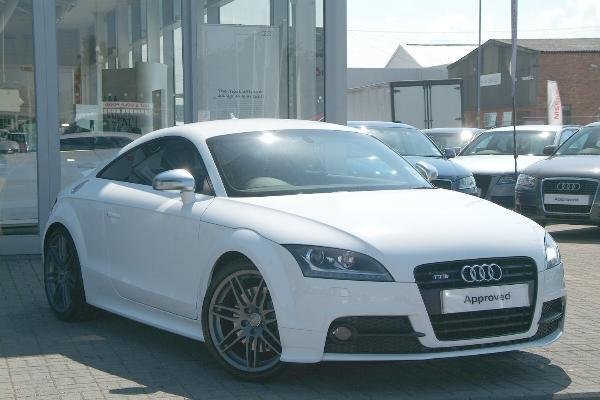

In [19]:
cars = CarsDataset(data, train_dir)
cars[0][0]

In [20]:
data

,filen,train_labels,class_name,body type
0,00001.jpg,14,Audi TTS Coupe 2012,Coupe
1,00002.jpg,3,Acura TL Sedan 2012,Sedan
2,00003.jpg,91,Dodge Dakota Club Cab 2007,Truck
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012,Sedan
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012,Truck
...,...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012,Van
8140,08141.jpg,196,smart fortwo Convertible 2012,Convertible
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009,Coupe
8142,08143.jpg,112,Ford GT Coupe 2006,Coupe


In [50]:
img_path = os.path.join(train_dir, '00001.jpg') # path to specific image
cars_ex = r'C:\Users\jtake\.cache\kagglehub\datasets\eduardo4jesus\stanford-cars-dataset\versions\1\cars_train\cars_train\00001.jpg'
img = Image.open(cars_ex).convert('RGB')

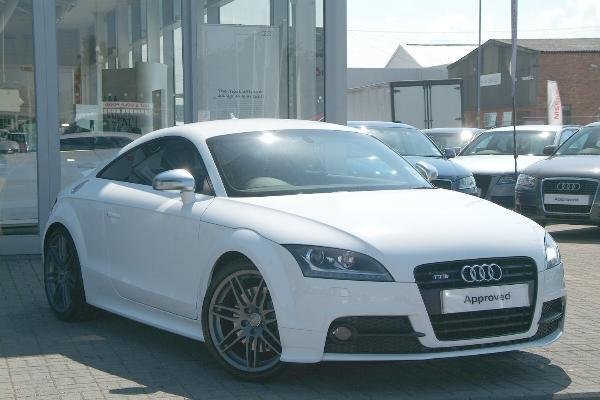

In [51]:
img